In [1]:
with open('../../raw_data/Sorted_cat.txt') as f:
    lines = f.readlines()

kept_cats = []
for line in lines:
    if line[0] != '#':
        kept_cats.append(line[:-1])

liste_Tchook, liste_romain, liste_etienne = [],[],[]
for index, line in enumerate(kept_cats):
    if index%3==0:
        liste_Tchook.append(line)
    if index%3==1:
        liste_romain.append(line)
    if index%3==2:
        liste_etienne.append(line)

In [2]:
# 15-44 fait
liste_etienne[34:45]

['peanut',
 'pig',
 'pizza',
 'rabbit',
 'rainbow',
 'sailboat',
 'scissors',
 'skateboard',
 'snail',
 'snowman',
 'spider']

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import math
import numpy as np
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm, trange
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.path import Path
from matplotlib.patches import Rectangle, PathPatch
from tensorflow import keras as K
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

# sys.path.append('../../SketchRNN_tf2')
from sketchrnn_ouatai import models, dataset, utils

sns.set('notebook', 'whitegrid', rc=utils.mpl_rc())

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))

2021-09-06 09:02:22.610024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-06 09:02:22.610070: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


tf: 2.6.0
tf.keras: 2.6.0


In [4]:
import IProgress
import ipywidgets
import random
from PIL import Image
import io
import pandas as pd

## dessine moi un objet

In [26]:
best_images = {
    'bulldozer': np.load('../../raw_data/Best_images/best_bulldozer_100_epochs.npy', allow_pickle=True),
    'rabbit' : np.load('../../raw_data/Best_images/best_rabbit.npy', allow_pickle=True), 
    'cat' : np.load('../../raw_data/Best_images/best_cat.npy', allow_pickle=True),
    'ant' : np.load('../../raw_data/Best_images/best_ant.npy', allow_pickle=True),
    'basket' : np.load('../../raw_data/Best_images/best_basket.npy', allow_pickle=True)
}
fichiers = {
        'bulldozer': 'sketch_rnn_bulldozer_weights.79_0.21.hdf5', 
        'cat' : 'sketch_rnn_cat_weights.78_0.01.hdf5',
        'rabbit' : 'sketch_rnn_rabbit_weights.100_0.06.hdf5',
        'ant' : 'Newly trained/models_sketch_rnn_ant_weights.100.hdf5',
        'basket' : 'Newly trained/models_sketch_rnn_basket_weights.200.hdf5'
               }
words = ['bulldozer', 'cat', 'rabbit', 'ant', 'basket']

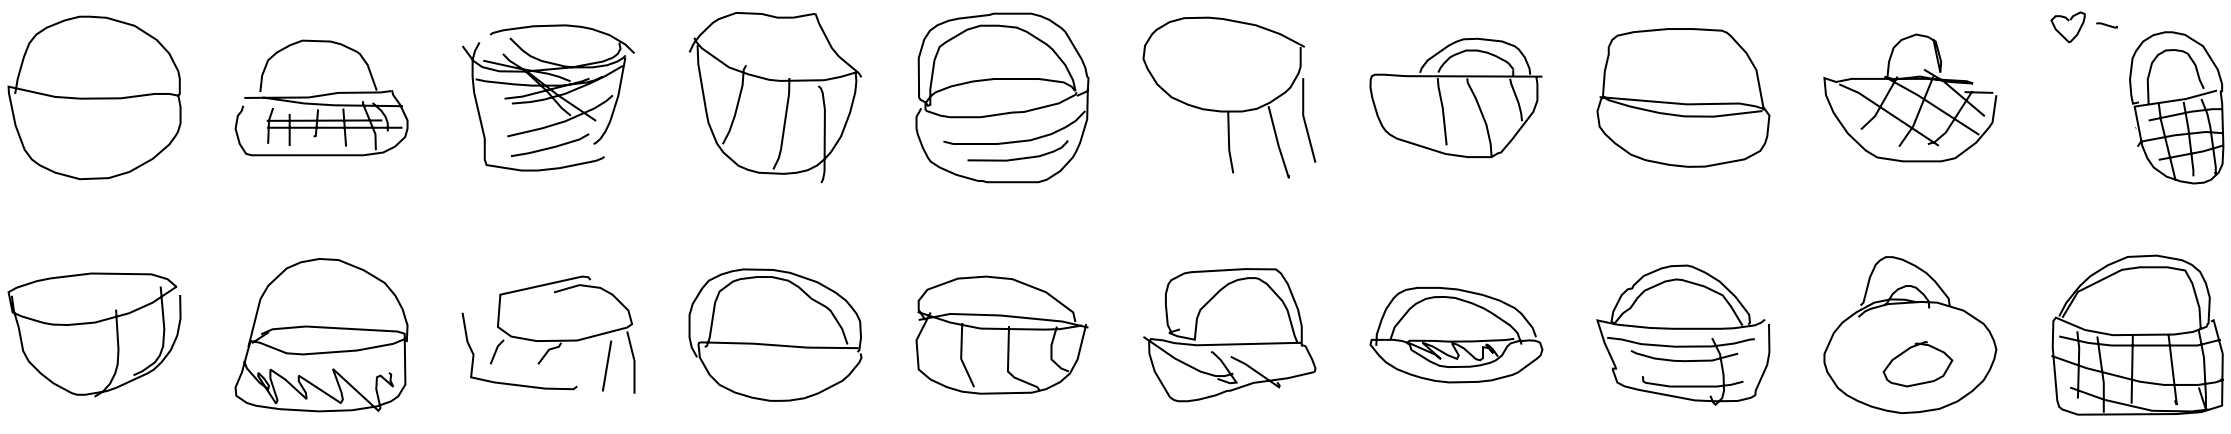

In [27]:
word = 'basket'
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for index, ax in enumerate(axs[0]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[word][index]))
for index, ax in enumerate(axs[1]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[word][index+10]))

In [28]:
def dessine_moi_un(word, temperature = 0.3, color = 'black', zoom = 1):
    
    if word not in words:
        return 'essaie un autre mot stp'
    
    #test de variables random
    max_seq_len = best_images[word][0].shape[0]-1
    data_train = [1 for k in range(10000)]
    
    hps = {
        "max_seq_len": max_seq_len,
        'batch_size': 100,
        "num_batches": math.ceil(len(data_train) / 100),
        "epochs": 1,
        "recurrent_dropout_prob": 0.1,
        "enc_rnn_size": 256,
        "dec_rnn_size": 512,
        "z_size": 128,
        "num_mixture": 20,
        "learning_rate": 0.001,
        "min_learning_rate": 0.00001,
        "decay_rate": 0.9999,
        "grad_clip": 1.0,
        'kl_tolerance': 0.2,
        'kl_decay_rate': 0.99995,
        "kl_weight": 0.5,
        'kl_weight_start': 0.01,
    }
    
    # load model
    sketchrnn = models.SketchRNN(hps)
    initial_epoch, initial_loss = 100, 0.06
    
    
    checkpoint = os.path.join('../../SketchRNN_tf2/models/', fichiers[word])
    sketchrnn.load_weights(checkpoint);
    
    
    # building image 
    best_pic = random.choice(best_images[word])
    d = np.expand_dims(best_pic,0)
    z = sketchrnn.models['encoder'].predict(d[:,1:])[0]
    strokes = sketchrnn.sample(z=z, temperature=temperature)
    
    final_object = utils.to_normal_strokes(strokes)
    figsize = (3*zoom,3*zoom)
    fig, ax = plt.subplots(figsize=figsize);
    utils.plot_strokes(ax, final_object, ec = color);
#     utils.plt_save(filename = '../../raw_data/Best_images/best_'+word+'.svg', facecolor = 'red')
#     plt.savefig(fname = '../../raw_data/Best_images/best_'+word+'.png', facecolor = background)
    
    # figure to PIL image
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    image = Image.open(buf)
#     image.save("../../raw_data/Best_images/best_cat_buffer.png")
    image = image.copy()
    buf.close()
    return image

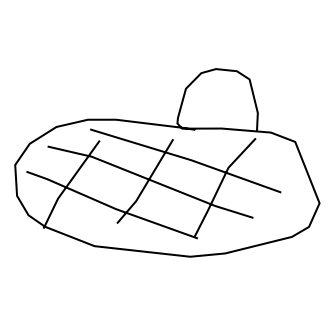

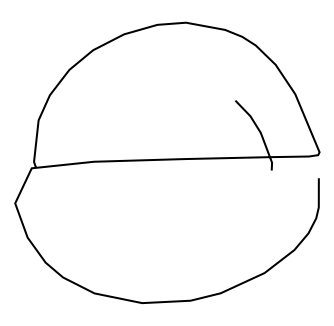

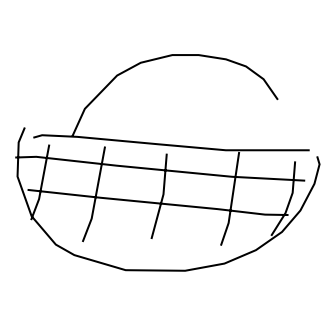

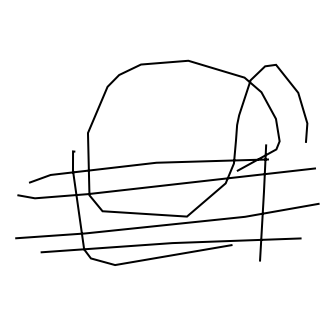

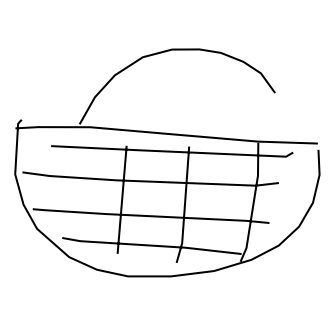

In [30]:
for k in range(5):
    dessine_moi_un('basket')

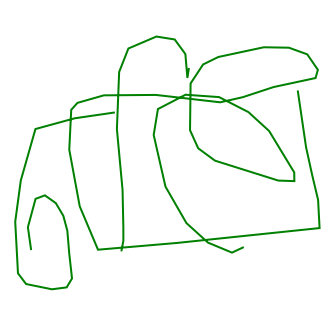

In [48]:
bulldozer = dessine_moi_un('bulldozer', color = 'green', zoom = 1)

In [54]:
type(bulldozer)

PIL.Image.Image

## la scene

In [34]:
scene_size = (2_000, 1_000)

In [35]:
def construis_la_scene(list_objects, scene_size = scene_size):
    '''
    list_objects = [[img_obj1, position_obj1], ...]
    '''
    scene = Image.new('RGBA', scene_size)
    for obj in list_objects:
        scene.paste(obj[0], obj[1])
    return scene

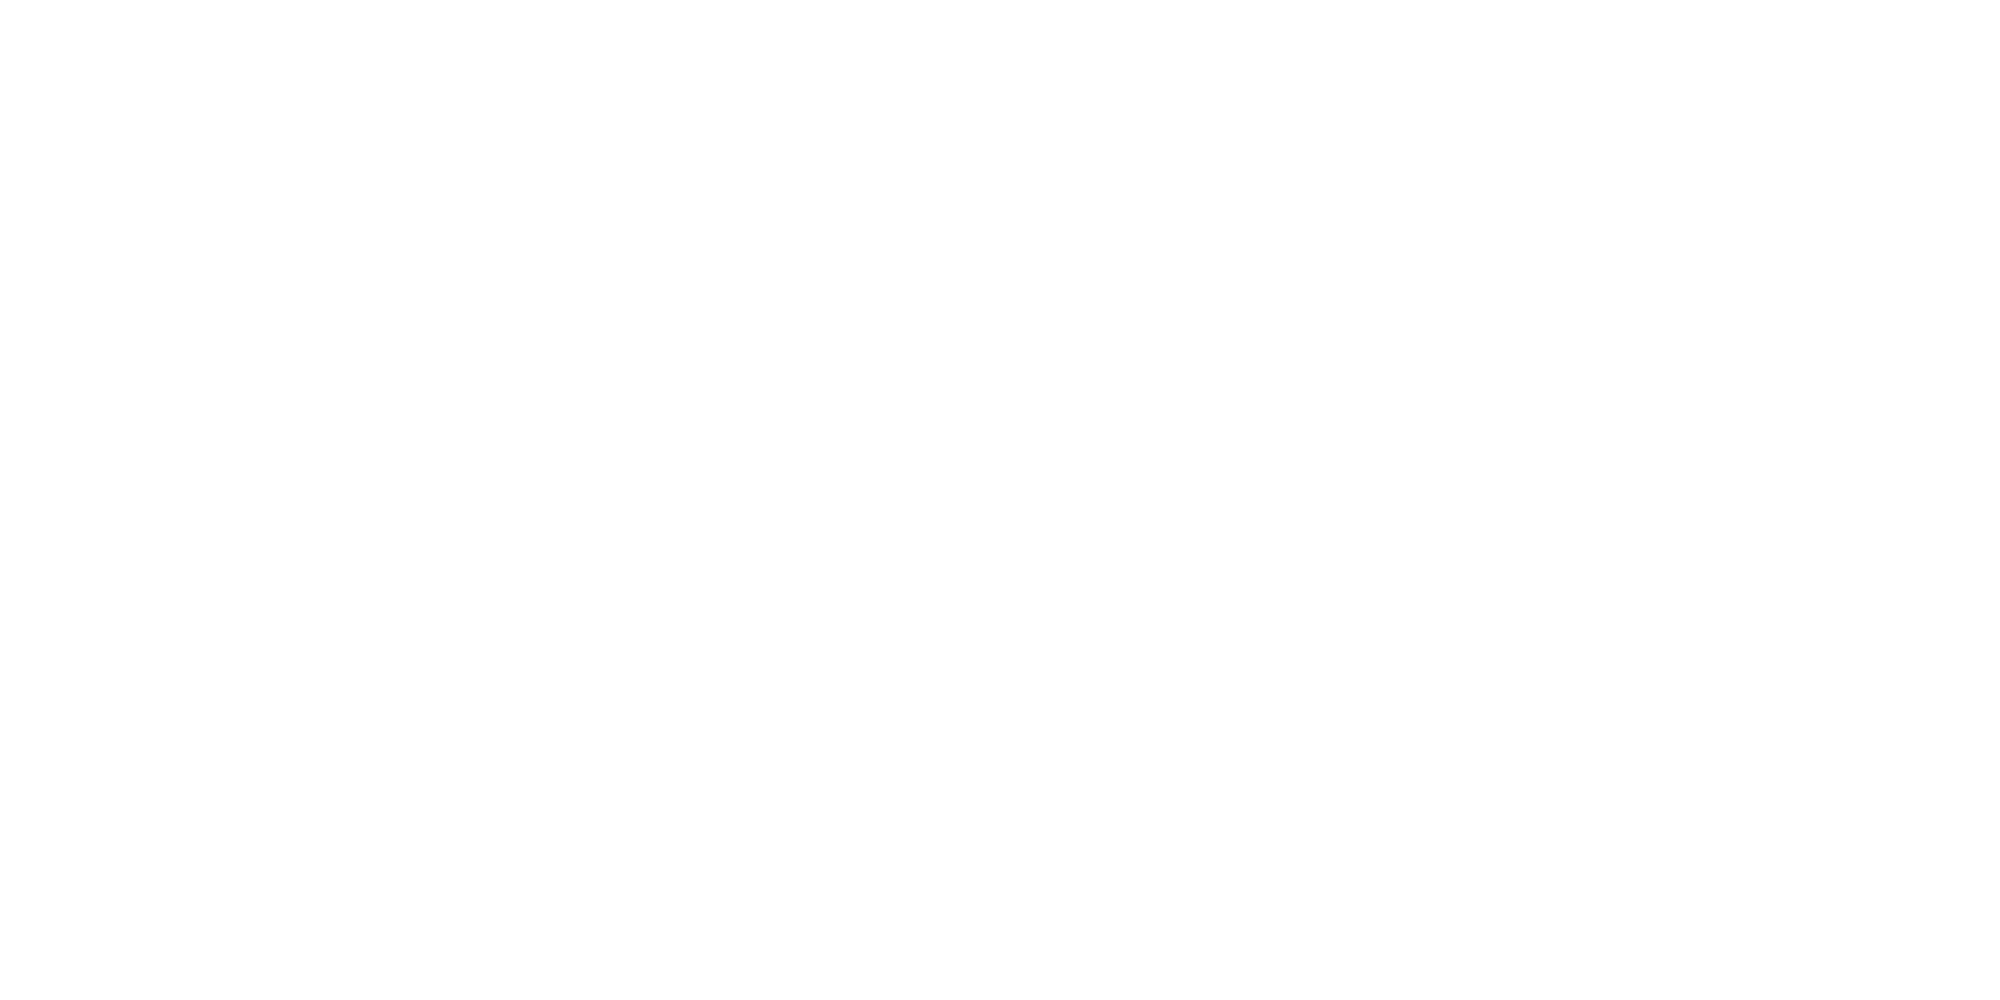

In [57]:

construis_la_scene([])

In [18]:
df = pd.DataFrame(np.array([['cat', 'blue', 'small', 3, 'centre', 'middle'], 
                             ['bulldozer', 'orange', 'big', 1, 'bottom', 'right'], 
                             ['rabbit', 'brown', 'medium', 1, 'top', 'left'],
                             ['rabbit', 'red', 'medium', 2, 'bottom', 'middle']
                            ]),
                   columns=['category', 'color', 'size', 'num', 'vertical_position', 'horizontal_position'])
df

,category,color,size,num,vertical_position,horizontal_position
0,cat,blue,small,3,centre,middle
1,bulldozer,orange,big,1,bottom,right
2,rabbit,brown,medium,1,top,left
3,rabbit,red,medium,2,bottom,middle


In [19]:
from PIL import ImageDraw

In [50]:
def df_to_scene(df, scene_size = scene_size):
    list_objects = []
    vertical_positions = {
        'top' : 0,
        'centre' : int(scene_size[1]/3),
        'bottom' : int(2*scene_size[1]/3)
    }
    horizontal_positions = {
        'left' : 0,
        'middle' : int(scene_size[0]/3),
        'right' : int(2*scene_size[0]/3)
    }
    sizes = {
        'small' : 1/2,
        'medium' : 1,
        'big' : 2
    }
  
    
    for index, row in df.iterrows():
        for n in range(int(row['num'])):
            category = row['category']
            color = row['color']
            size = sizes[row['size']]
            
            #position
            hor = horizontal_positions[row['horizontal_position']]
            vert = vertical_positions[row['vertical_position']]
            
            image = dessine_moi_un(category, color = color, zoom = size)
            print(f'category {category} image {n}')
            print('coords coin', hor, vert)
            
#             if scene_size[0]/3 - image.size[0]>0 and scene_size[1]/3 - image.size[1]>0:
#                 rd_hor = int(random.uniform(hor, hor + scene_size[0]/3 - image.size[0]))
#                 rd_vert = int(random.uniform(hor, hor + scene_size[1]/3 - image.size[1]))
#                 list_objects.append([image, (rd_hor, rd_vert)])
#                 print('coords random', rd_hor, rd_vert)
            
#             else : 
            list_objects.append([image, (hor, vert)])          
    draw = ImageDraw.Draw(image)
    for h in range(scene_size[0]):
        draw.point((h,horizontal_positions['left']), fill="black")
    
    return construis_la_scene(list_objects, scene_size)

category cat image 0
coords coin 666 333
category cat image 1
coords coin 666 333
category cat image 2
coords coin 666 333
category bulldozer image 0
coords coin 1333 666
category rabbit image 0
coords coin 0 0
category rabbit image 0
coords coin 666 666
category rabbit image 1
coords coin 666 666
CPU times: user 22.8 s, sys: 867 ms, total: 23.6 s
Wall time: 19.7 s


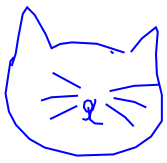

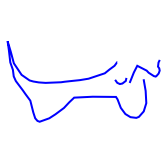

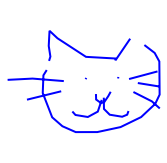

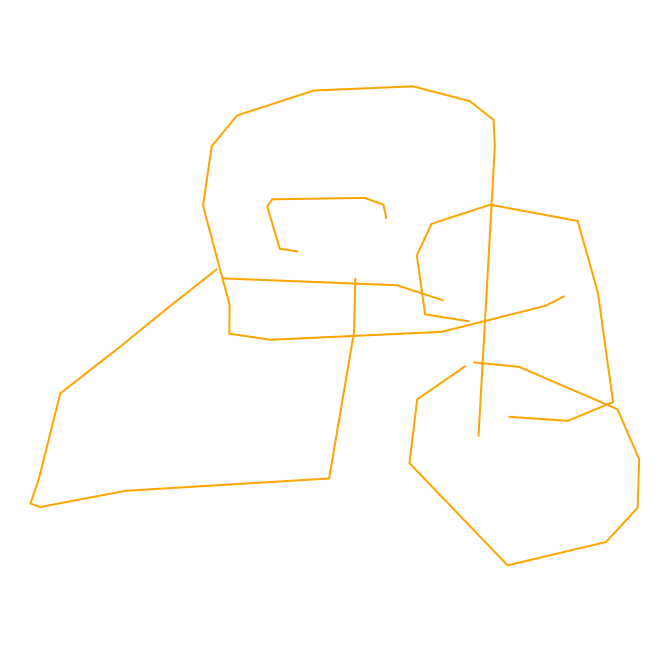

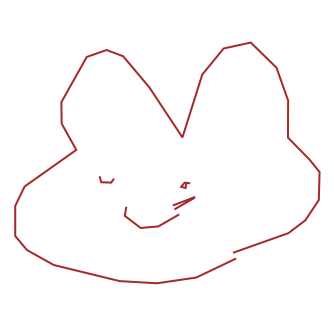

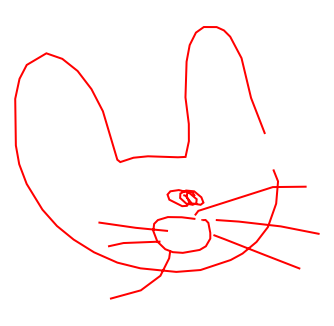

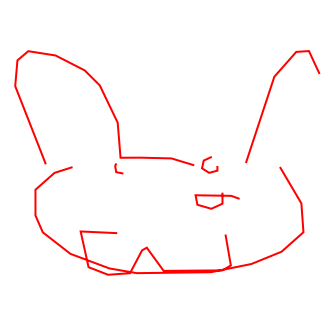

In [53]:
%%time
scene = df_to_scene(df)

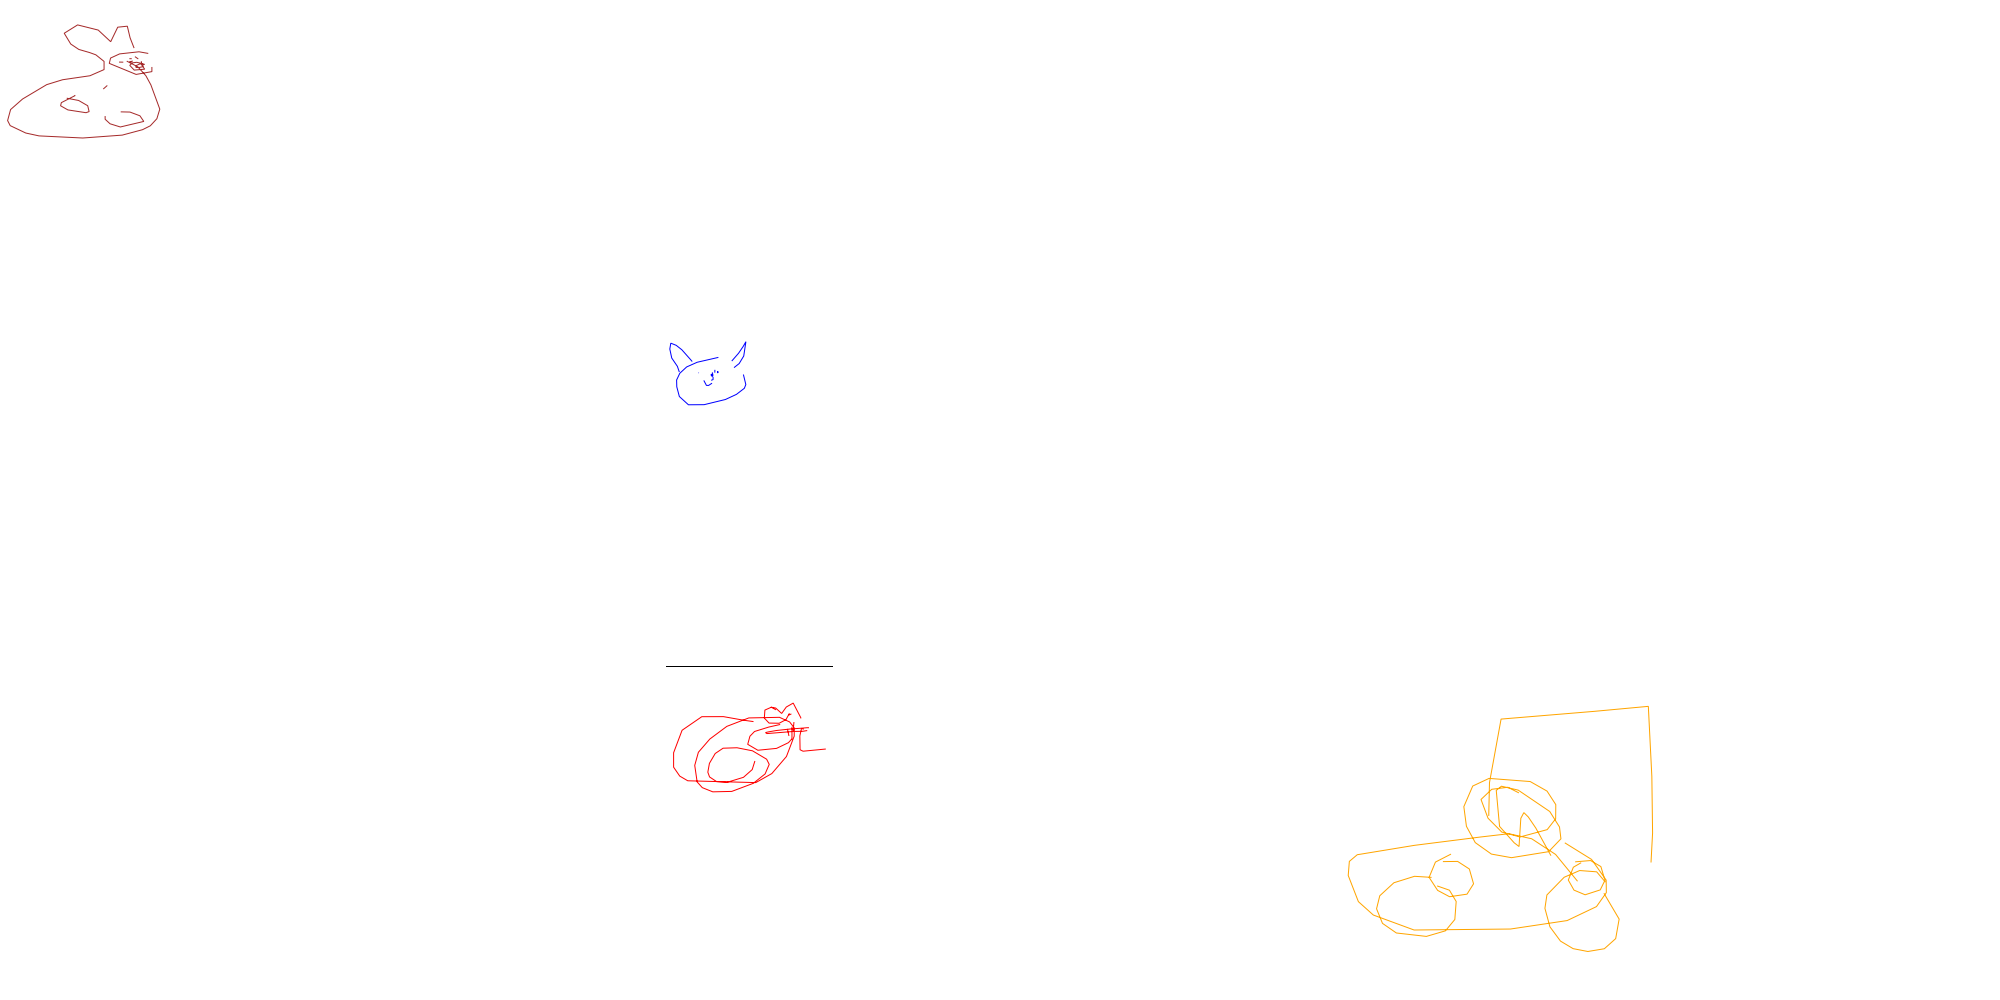

In [52]:
scene